In [860]:
import numpy as np
import pandas as pd

hydration_after_p = 0.76
hydration_before_p = 0.045
#Wet Weight(g) after pretreatment
#2% 1h, 12% 1h, 2% 3h 12% 3h
w_60c= np.array([7.8302,4.0316,5.45,4.48]) 
w_80c= np.array([6.4508, 5.181, 5.929, 3.9756]) 
w_100c = np.array([5.6054, 4.1634, 5.9361, 3.9318]) 
w_120c = np.array([4.8918, 3.3319, 5.1648, 2.9348]) 

#Dry Weight(g) after pretreatment
dry_w_60c = w_60c * (1-hydration_after_p)
dry_w_80c = w_80c * (1-hydration_after_p)
dry_w_100c = w_100c * (1-hydration_after_p)
dry_w_120c = w_120c * (1-hydration_after_p)

avg_lost_w_60c = dry_w_60c/2
avg_lost_w_80c = dry_w_80c/2
avg_lost_w_100c = dry_w_100c/2
avg_lost_w_120c = dry_w_120c/2

avg_lost_w_60c, avg_lost_w_80c, avg_lost_w_100c, avg_lost_w_120c

(array([0.939624, 0.483792, 0.654   , 0.5376  ]),
 array([0.774096, 0.62172 , 0.71148 , 0.477072]),
 array([0.672648, 0.499608, 0.712332, 0.471816]),
 array([0.587016, 0.399828, 0.619776, 0.352176]))

In [861]:
def calculate_dry_weight(w, hydration_after_p):
    return w * (1 - hydration_after_p)

def calculate_hplc(hplc, k, m, dilution_factor=5):
    return np.array([dilution_factor*(value-m)/k for value in hplc])

def calculate_mass(c, volume_H):
    return c * volume_H

def calculate_max(values, dry_masses):
    return [values[i]*value for i, value in enumerate(dry_masses)]

def calculate_yield(m, max_m):
    return np.divide(m, max_m)

def calculate_average(pairs):
    return np.mean(pairs, axis=1)

def reshape_into_pairs(array):
    return array.reshape(-1, 2)

def format(input_array):
    multiplied_array = input_array * 100
    str_array = np.array(multiplied_array, dtype=str)
    extracted_array = np.array([x[:4] for x in str_array])
    return extracted_array

def format2(input_array):
    str_array = np.array(input_array, dtype=str)
    extracted_array = np.array([x[:4] for x in str_array])
    return extracted_array

def compensate_for_hydration(array, dry_masses_after_p ):
    sample_weight = 2*(1-hydration_after_p)
    multiply_factor_over_pretreatment = dry_masses_after_p/sample_weight
    #print(f"multiply_factor_over_pretreatment: {multiply_factor_over_pretreatment}")
    return array*multiply_factor_over_pretreatment


In [862]:
def preprocess_data(G_samples_hplc, XMG_samples_hplc, glucose_yields, xylmangal_values, volume, dry_masses_after_p, dry_masses_before_p):
    
    pairs_G_C = reshape_into_pairs(G_samples_hplc)
    pairs_XMG_C = reshape_into_pairs(XMG_samples_hplc)

    avgs_G_C = calculate_average(pairs_G_C)
    avgs_XMG_C = calculate_average(pairs_XMG_C)
  
    c_G = calculate_hplc(avgs_G_C, k=315718, m=4623)
    c_XMG = calculate_hplc(avgs_XMG_C, k=317400, m=10216)
    #c_G = calculate_hplc(avgs_G_C, k=298500, m=7400)
    #c_XMG = calculate_hplc(avgs_XMG_C, k=298500, m=29000)
    
    m_G_before = calculate_mass(c_G, volume)
    m_XMG_before = calculate_mass(c_XMG, volume)

    #print(f"m_G_before: {m_G_before}")
    #print(f"m_XMG_before: {m_XMG_before}")
    #print(F"dry_masses_after_p: {dry_masses_after_p}")
    #Kompensera för att vi inte tog allt när vi gjorde hplc
    m_G = compensate_for_hydration(m_G_before, dry_masses_after_p)
    m_XMG = compensate_for_hydration(m_XMG_before, dry_masses_after_p)

    
    #Yield
    yield_glucose_procent_process = calculate_yield(m_G, dry_masses_before_p)
    yield_XMG_procent_process = calculate_yield(m_XMG, dry_masses_before_p)
    yield_monosacharides_procent_process = np.add(yield_glucose_procent_process, yield_XMG_procent_process)

    #Selectivity
    selectivity_glucose_procent_process = np.divide(m_G, dry_masses_after_p)
    selectivity_XMG_procent_process = np.divide(m_XMG, dry_masses_after_p)
    selectivity_monosacharices_procent_process = np.divide(m_G+m_XMG, dry_masses_after_p)
    

    results = {
        "Dry W Milled(g)": format2(dry_masses_before_p),
        "Dry W after Pretreatment(g)": format2(dry_masses_after_p),

        "Glucose(g) ": format2(m_G),
        "XMG(g)": format2(m_XMG),
        "Monosacharides(g)": format2(np.add(m_G, m_XMG)),

        "Selctivity Glucose (%)": format(selectivity_glucose_procent_process),
        "Selctivity XMG (%)": format(selectivity_XMG_procent_process),
        "Selctivity Monosacharides (%)": format(selectivity_monosacharices_procent_process),

        "Yield Glucose (%)": format(yield_glucose_procent_process),
        "Yield XMG (%)": format(yield_XMG_procent_process),
        "Yield Monosacharides (%)": format(yield_monosacharides_procent_process),
    }

    return results

In [863]:
"""
#Varmast 1h, varmast 3h, kallast 1h, kallast 3h
#Ex 120C 1h, 120C 3h, 60C 1h, 60C 3h

#CHANGE THESE
milled_masses = np.array([2.0924,2.0960,2.0954,2.0985,2.0923,2.0979,2.0962,2.0943])
Glucose_samples_hplc = np.array([590520.1774,  626867.5736, 693851.4441, 661331.5045, 578989.8003, 675418.0375, 571507.7927, 596580.4333])
XMG_samples_hplc = np.array([149706.8617, 159126.8929,  176542.8571,  168805.7143,  147914.2857,  172857.1429,  146857.1429,  153200.0000])

#Constants
glucose_yields = np.array([39.54, 88.30, 68.42, 65.11, 56.28])/100
xylmangal_values = np.array([25.24, 2.64, 1.97, 9.96, 7.4])/100
volume = 0.02485
hydration_after_p = 0.8

dry_masses_before_p = milled_masses*0.955
average_dry_masses_before_pretreatment = calculate_average(reshape_into_pairs(dry_masses_before_p))
a = average_dry_masses_before_pretreatment

#CHANGE THIS 
dry_masses_after_p = np.array([a[0]*avg_lost_w_120c[0], a[1]*avg_lost_w_120c[2], a[2]*avg_lost_w_60c[0], a[3]*avg_lost_w_60c[2]])
"""

'\n#Varmast 1h, varmast 3h, kallast 1h, kallast 3h\n#Ex 120C 1h, 120C 3h, 60C 1h, 60C 3h\n\n#CHANGE THESE\nmilled_masses = np.array([2.0924,2.0960,2.0954,2.0985,2.0923,2.0979,2.0962,2.0943])\nGlucose_samples_hplc = np.array([590520.1774,  626867.5736, 693851.4441, 661331.5045, 578989.8003, 675418.0375, 571507.7927, 596580.4333])\nXMG_samples_hplc = np.array([149706.8617, 159126.8929,  176542.8571,  168805.7143,  147914.2857,  172857.1429,  146857.1429,  153200.0000])\n\n#Constants\nglucose_yields = np.array([39.54, 88.30, 68.42, 65.11, 56.28])/100\nxylmangal_values = np.array([25.24, 2.64, 1.97, 9.96, 7.4])/100\nvolume = 0.02485\nhydration_after_p = 0.8\n\ndry_masses_before_p = milled_masses*0.955\naverage_dry_masses_before_pretreatment = calculate_average(reshape_into_pairs(dry_masses_before_p))\na = average_dry_masses_before_pretreatment\n\n#CHANGE THIS \ndry_masses_after_p = np.array([a[0]*avg_lost_w_120c[0], a[1]*avg_lost_w_120c[2], a[2]*avg_lost_w_60c[0], a[3]*avg_lost_w_60c[2]])\

In [864]:

"""
data = preprocess_data(Glucose_samples_hplc, XMG_samples_hplc, glucose_yields, xylmangal_values, volume, dry_masses_after_p, dry_masses_before_p)


index = ['120C 1h', '120C 3h', '60C 1h', '60C 3h']
process_data_keys = [
    "Dry W Milled(g)",
    "Dry W after Pretreatment(g)",
    "Glucose(g) ",
    "XMG(g)",
    "Monosacharides(g)",
    "Yield Glucose (%)",
    "Yield XMG (%)",
    "Yield Monosacharides (%)",
    "Selctivity Glucose (%)",
    "Selctivity XMG (%)",
    "Selctivity Monosacharides (%)"
]

# Create dataframes
process_data = {key: data[key] for key in process_data_keys}
process_df = pd.DataFrame(process_data)
process_df.index = index

print('2% NaOH batch - Process Data')
print(f"NREL Yield Glucose: {39.54}")
print(f"NREL Yield XMG: {25.24}")
print(f"NREL Yield Monosacharides: {39.54+25.24}")
print()
process_df
"""


'\ndata = preprocess_data(Glucose_samples_hplc, XMG_samples_hplc, glucose_yields, xylmangal_values, volume, dry_masses_after_p, dry_masses_before_p)\n\n\nindex = [\'120C 1h\', \'120C 3h\', \'60C 1h\', \'60C 3h\']\nprocess_data_keys = [\n    "Dry W Milled(g)",\n    "Dry W after Pretreatment(g)",\n    "Glucose(g) ",\n    "XMG(g)",\n    "Monosacharides(g)",\n    "Yield Glucose (%)",\n    "Yield XMG (%)",\n    "Yield Monosacharides (%)",\n    "Selctivity Glucose (%)",\n    "Selctivity XMG (%)",\n    "Selctivity Monosacharides (%)"\n]\n\n# Create dataframes\nprocess_data = {key: data[key] for key in process_data_keys}\nprocess_df = pd.DataFrame(process_data)\nprocess_df.index = index\n\nprint(\'2% NaOH batch - Process Data\')\nprint(f"NREL Yield Glucose: {39.54}")\nprint(f"NREL Yield XMG: {25.24}")\nprint(f"NREL Yield Monosacharides: {39.54+25.24}")\nprint()\nprocess_df\n'

In [865]:
def create_dataframe(Glucose_samples_hplc, XMG_samples_hplc, indices, dry_masses_after_p,dry_masses_before_p):
    #Constants
    volume = 0.02485
    glucose_yields = np.array([39.54, 88.30, 68.42, 65.11, 56.28])/100,
    xylmangal_values = np.array([25.24, 2.64, 1.97, 9.96, 7.4])/100
    

    data = preprocess_data(Glucose_samples_hplc, XMG_samples_hplc, glucose_yields, xylmangal_values, volume, dry_masses_after_p, dry_masses_before_p)

    process_data_keys = [
        "Dry W Milled(g)",
        "Dry W after Pretreatment(g)",
        "Glucose(g) ",
        "XMG(g)",
        "Monosacharides(g)",
        "Yield Glucose (%)",
        "Yield XMG (%)",
        "Yield Monosacharides (%)",
        "Selctivity Glucose (%)",
        "Selctivity XMG (%)",
        "Selctivity Monosacharides (%)"
    ]

    # Create dataframes
    process_data = {key: data[key] for key in process_data_keys}
    process_df = pd.DataFrame(process_data)
    process_df.index = indices

   

    return process_df


In [866]:
#2% NaOH 60-120%
milled_masses_1 = np.array([2.0924, 2.0960, 2.0954, 2.0985, 2.0923, 2.0979, 2.0962, 2.0943])
dry_masses_before_p_1 = milled_masses_1*0.955
avg_before_p_1 = calculate_average(reshape_into_pairs(dry_masses_before_p_1))
a_1 = avg_before_p_1
dry_masses_after_p_1 = np.array([a_1[0]*avg_lost_w_120c[0], a_1[1]*avg_lost_w_120c[2], a_1[2]*avg_lost_w_60c[0], a_1[3]*avg_lost_w_60c[2]])


#12% NaOH 60-120% 
milled_masses_2 = np.array([2.0924, 2.0960, 2.0954, 2.0985, 2.0923, 2.0979, 2.0962, 2.0943])
dry_masses_before_p_2 = milled_masses_2*0.955
avg_before_p_2 = calculate_average(reshape_into_pairs(dry_masses_before_p_2))
a_2 = avg_before_p_2
dry_masses_after_p_2 = np.array([a_2[0]*avg_lost_w_120c[1], a_2[1]*avg_lost_w_120c[3], a_2[2]*avg_lost_w_60c[1], a_2[3]*avg_lost_w_60c[3]])


#12% NaOH 80-100%
milled_masses_3 = np.array([2.0003, 2.0024, 1.9970, 2.0050, 2.0008, 1.9008, 1.9980, 2.002])
dry_masses_before_p_3 = milled_masses_3*0.955
avg_before_p_3 = calculate_average(reshape_into_pairs(dry_masses_before_p_3))
a_3 = avg_before_p_3
dry_masses_after_p_3 = np.array([a_3[0]*avg_lost_w_100c[1], a_3[1]*avg_lost_w_100c[3], a_3[2]*avg_lost_w_80c[1], a_3[3]*avg_lost_w_80c[3]])


#2% NaOH 80-100%
milled_masses_4 = np.array([2.0040, 1.9977, 1.9997, 2.0030, 2.0003, 1.9984, 2.0020, 1.9966])
dry_masses_before_p_4 = milled_masses_4*0.955
avg_before_p_4 = calculate_average(reshape_into_pairs(dry_masses_before_p_4))
a_4 = avg_before_p_4
dry_masses_after_p_4 = np.array([a_4[0]*avg_lost_w_100c[0], a_4[1]*avg_lost_w_100c[2], a_4[2]*avg_lost_w_80c[0], a_4[3]*avg_lost_w_80c[2]])

#avg_before_p_1, avg_before_p_2, avg_before_p_3, avg_before_p_4
dry_masses_after_p_1, dry_masses_after_p_2, dry_masses_after_p_3, dry_masses_after_p_4

(array([1.17400911, 1.24115552, 1.88001896, 1.30863029]),
 array([0.79964041, 0.70526317, 0.96798095, 1.07571811]),
 array([0.9548954 , 0.90161914, 1.15827306, 0.91120752]),
 array([1.2853037 , 1.36147249, 1.47804284, 1.35845118]))

In [867]:
studies = [
    {
        "Glucose_samples_hplc": np.array([590520.1774, 626867.5736, 693851.4441, 661331.5045, 578989.8003, 675418.0375, 571507.7927, 596580.4333]),
        "XMG_samples_hplc": np.array([149706.8617, 159126.8929, 176542.8571, 168805.7143, 147914.2857, 172857.1429, 146857.1429, 153200.0000]),
        "dry_masses_after_p": dry_masses_after_p_1,
        "dry_masses_before_p": avg_before_p_1,
        "indices": ['120C 1h', '120C 3h', '60C 1h', '60C 3h']
     },
    {
        "Glucose_samples_hplc": np.array([1164687.9925, 1166254.1841, 1219303.4481, 1217971.6083, 772940.5642, 800664.2413, 816496.2310, 777523.5907]),
        "XMG_samples_hplc": np.array([0, 0, 0, 0, 103180.0916, 106556.1953, 79071.6490, 74139.5075]),
        "dry_masses_after_p": dry_masses_after_p_2,
        "dry_masses_before_p": avg_before_p_2,
        "indices": ['120C 1h', '120C 3h', '60C 1h', '60C 3h']
    },
    {
        "Glucose_samples_hplc": np.array([1084281.8242, 1437375.2409, 1095570.4941, 1269949.5440, 0,0, 1125741.7195, 1193543.1789]),
        "XMG_samples_hplc": np.array([0, 97365.4265, 0, 0, 0, 0, 0, 0]),
        "dry_masses_after_p": dry_masses_after_p_3,
        "dry_masses_before_p": avg_before_p_3,
        "indices": ['100C 1h', '100C 3h', '80C 1h', '80C 3h']

    },
    {
        "Glucose_samples_hplc": np.array([804353.4156, 739282.6040, 745575.4034, 745801.7998, 727440.5672, 924715.2307, 880340.6993, 899655.9408]),
        "XMG_samples_hplc": np.array([0, 154173.2942, 195054.4891, 202082.0536, 159049.2005, 205812.6120, 189111.6415, 190132.9875]),
        "dry_masses_after_p": dry_masses_after_p_4,
        "dry_masses_before_p": avg_before_p_4,
        "indices": ['100C 1h', '100C 3h', '80C 1h', '80C 3h']
    }
]

# For each study, create a dataframe and store it in a list
dataframes = []


print()
print("Data for studies of various pretreatment conditions:")
print()
print(f"NREL Data:")
print(f"NREL Yield Glucose: {39.54}")
print(f"NREL Yield XMG: {25.24}")
print(f"NREL Yield Monosacharides: {39.54+25.24}")
print()
labels = [['2% 60-120'], ['12% 60-120'], ['12% 80-100'], ['2% 80-100']]
for i, study in enumerate(studies):
    df = create_dataframe(**study)
    styled_df = df.style.background_gradient(cmap='viridis')
    dataframes.append(styled_df)
    print(f'Data for study: {labels[i][0]}:')
    display(styled_df)




Data for studies of various pretreatment conditions:

NREL Data:
NREL Yield Glucose: 39.54
NREL Yield XMG: 25.24
NREL Yield Monosacharides: 64.78

Data for study: 2% 60-120:


,Dry W Milled(g),Dry W after Pretreatment(g),Glucose(g),XMG(g),Monosacharides(g),Yield Glucose (%),Yield XMG (%),Yield Monosacharides (%),Selctivity Glucose (%),Selctivity XMG (%),Selctivity Monosacharides (%)
120C 1h,1.99,1.17,0.58,0.13,0.71,29.0,6.90,35.9,49.5,11.7,61.2
120C 3h,2.00,1.24,0.68,0.16,0.84,34.1,8.21,42.4,55.1,13.2,68.4
60C 1h,2.00,1.88,0.95,0.23,1.18,47.9,11.5,59.4,51.0,12.2,63.2
60C 3h,2.00,1.30,0.62,0.14,0.77,31.0,7.45,38.5,47.5,11.4,58.9


Data for study: 12% 60-120:


,Dry W Milled(g),Dry W after Pretreatment(g),Glucose(g),XMG(g),Monosacharides(g),Yield Glucose (%),Yield XMG (%),Yield Monosacharides (%),Selctivity Glucose (%),Selctivity XMG (%),Selctivity Monosacharides (%)
120C 1h,1.99,0.79,0.76,-0.0,0.75,38.0,-0.3,37.7,95.1,-0.8,94.3
120C 3h,2.00,0.70,0.70,-0.0,0.69,35.0,-0.2,34.7,99.5,-0.8,98.7
60C 1h,2.00,0.96,0.62,0.07,0.69,31.0,3.73,34.7,64.1,7.71,71.8
60C 3h,2.00,1.07,0.69,0.05,0.75,34.9,2.91,37.8,64.9,5.41,70.3


Data for study: 12% 80-100:


,Dry W Milled(g),Dry W after Pretreatment(g),Glucose(g),XMG(g),Monosacharides(g),Yield Glucose (%),Yield XMG (%),Yield Monosacharides (%),Selctivity Glucose (%),Selctivity XMG (%),Selctivity Monosacharides (%)
100C 1h,1.91,0.95,0.98,0.02,1.01,51.4,1.56,53.0,102.,3.13,106.
100C 3h,1.91,0.90,0.87,-0.0,0.86,45.5,-0.3,45.1,96.5,-0.8,95.7
80C 1h,1.86,1.15,-0.0,-0.0,-0.0,-0.2,-0.5,-0.7,-0.3,-0.8,-1.2
80C 3h,1.90,0.91,0.86,-0.0,0.85,45.1,-0.3,44.7,94.6,-0.8,93.8


Data for study: 2% 80-100:


,Dry W Milled(g),Dry W after Pretreatment(g),Glucose(g),XMG(g),Monosacharides(g),Yield Glucose (%),Yield XMG (%),Yield Monosacharides (%),Selctivity Glucose (%),Selctivity XMG (%),Selctivity Monosacharides (%)
100C 1h,1.91,1.28,0.80,0.07,0.87,42.3,3.66,45.9,62.9,5.45,68.3
100C 3h,1.91,1.36,0.82,0.20,1.03,43.2,10.9,54.2,60.7,15.3,76.1
80C 1h,1.90,1.47,0.99,0.20,1.20,52.1,10.8,63.0,67.3,14.0,81.3
80C 3h,1.90,1.35,0.98,0.19,1.18,51.6,10.4,62.0,72.5,14.6,87.2


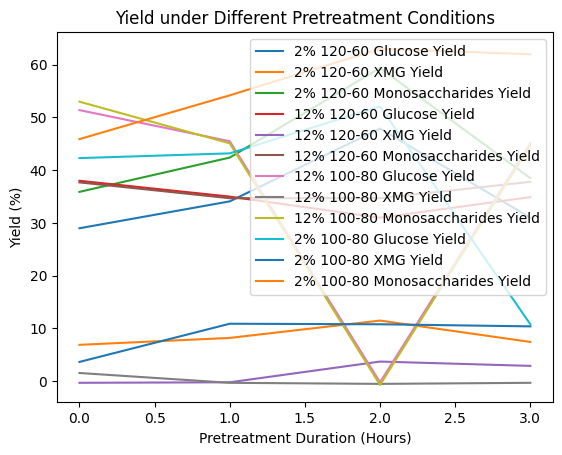

In [868]:
import matplotlib.pyplot as plt

# organize data into a dictionary
data = {
    '2% 120-60': {
        'Glucose Yield': [29.0, 34.1, 47.9, 31.0],
        'XMG Yield': [6.90, 8.21, 11.5, 7.45],
        'Monosaccharides Yield': [35.9, 42.4, 59.4, 38.5],
    },
    '12% 120-60': {
        'Glucose Yield': [38.0, 35.0, 31.0, 34.9],
        'XMG Yield': [-0.3, -0.2, 3.73, 2.91],
        'Monosaccharides Yield': [37.7, 34.7, 34.7, 37.8],
    },
    '12% 100-80': {
        'Glucose Yield': [51.4, 45.5, -0.2, 45.1],
        'XMG Yield': [1.56, -0.3, -0.5, -0.3],
        'Monosaccharides Yield': [53.0, 45.1, -0.7, 44.7],
    },
    '2% 100-80': {
        'Glucose Yield': [42.3,43.2,52.1,10.8],
        'XMG Yield': [3.66,10.9,10.8,10.4],
        'Monosaccharides Yield': [45.9,54.2,63,62],
    },
}

# initialize the plot
fig, ax = plt.subplots()

# add data to the plot
for study, results in data.items():
    ax.plot(results['Glucose Yield'], label=f'{study} Glucose Yield')
    ax.plot(results['XMG Yield'], label=f'{study} XMG Yield')
    ax.plot(results['Monosaccharides Yield'], label=f'{study} Monosaccharides Yield')

# set up labels and title
ax.set_xlabel('Pretreatment Duration (Hours)')
ax.set_ylabel('Yield (%)')
ax.set_title('Yield under Different Pretreatment Conditions')

# add legend to the plot
ax.legend()

# display the plot
plt.show()


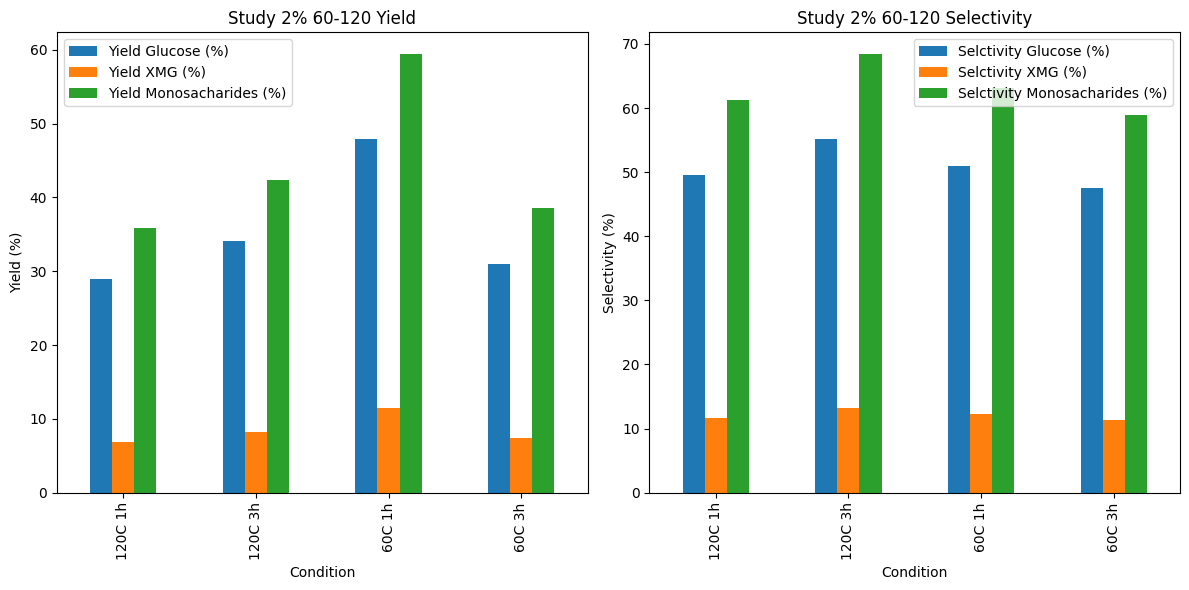

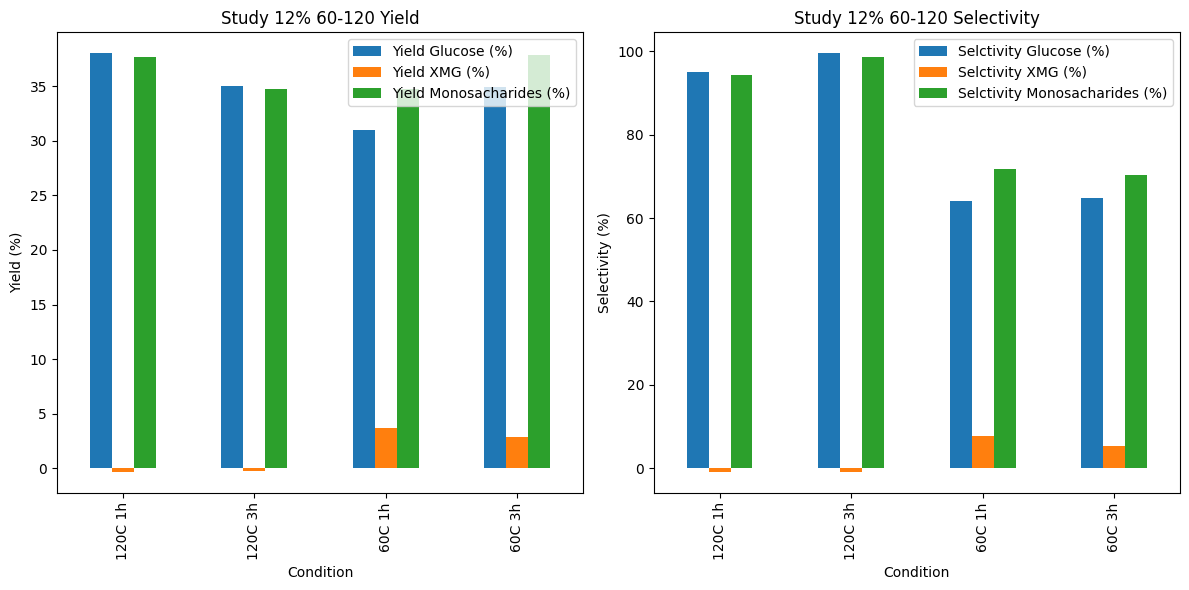

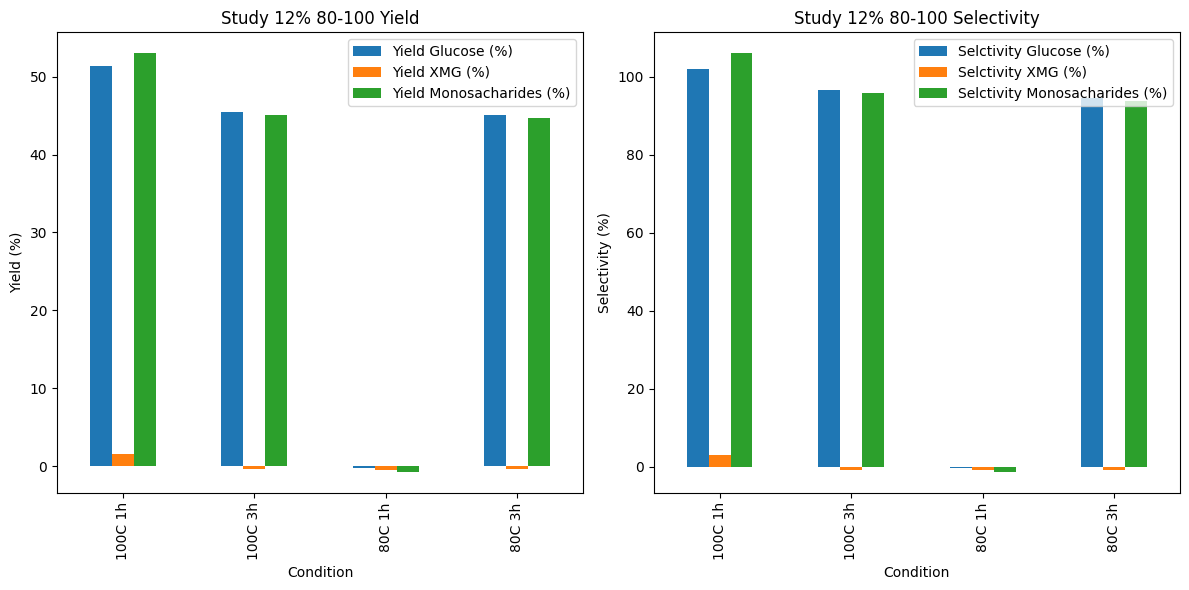

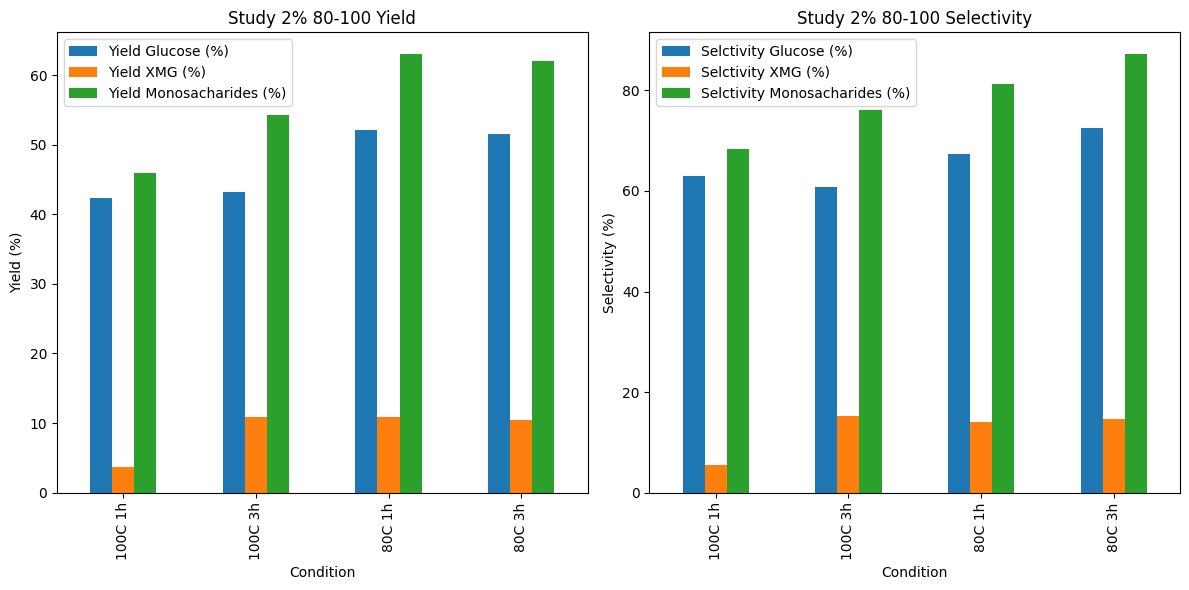

In [869]:
import pandas as pd

# Study 1: 2% 60-120
# Study: 2% 60-120
data1 = {
    'Dry W Milled(g)': [1.99, 2.00, 2.00, 2.00],
    'Dry W after Pretreatment(g)': [1.17, 1.24, 1.88, 1.30],
    'Glucose(g)': [0.58, 0.68, 0.95, 0.62],
    'XMG(g)': [0.13, 0.16, 0.23, 0.14],
    'Monosacharides(g)': [0.71, 0.84, 1.18, 0.77],
    'Yield Glucose (%)': [29.0, 34.1, 47.9, 31.0],
    'Yield XMG (%)': [6.90, 8.21, 11.5, 7.45],
    'Yield Monosacharides (%)': [35.9, 42.4, 59.4, 38.5],
    'Selctivity Glucose (%)': [49.5, 55.1, 51.0, 47.5],
    'Selctivity XMG (%)': [11.7, 13.2, 12.2, 11.4],
    'Selctivity Monosacharides (%)': [61.2, 68.4, 63.2, 58.9]
}

# Study: 12% 60-120
data2 = {
    'Dry W Milled(g)': [1.99, 2.00, 2.00, 2.00],
    'Dry W after Pretreatment(g)': [0.79, 0.70, 0.96, 1.07],
    'Glucose(g)': [0.76, 0.70, 0.62, 0.69],
    'XMG(g)': [-0.0, -0.0, 0.07, 0.05],
    'Monosacharides(g)': [0.75, 0.69, 0.69, 0.75],
    'Yield Glucose (%)': [38.0, 35.0, 31.0, 34.9],
    'Yield XMG (%)': [-0.3, -0.2, 3.73, 2.91],
    'Yield Monosacharides (%)': [37.7, 34.7, 34.7, 37.8],
    'Selctivity Glucose (%)': [95.1, 99.5, 64.1, 64.9],
    'Selctivity XMG (%)': [-0.8, -0.8, 7.71, 5.41],
    'Selctivity Monosacharides (%)': [94.3, 98.7, 71.8, 70.3]
}

# Study: 12% 80-100
data3 = {
    'Dry W Milled(g)': [1.91, 1.91, 1.86, 1.90],
    'Dry W after Pretreatment(g)': [0.95, 0.90, 1.15, 0.91],
    'Glucose(g)': [0.98, 0.87, -0.0, 0.86],
    'XMG(g)': [0.02, -0.0, -0.0, -0.0],
    'Monosacharides(g)': [1.01, 0.86, -0.0, 0.85],
    'Yield Glucose (%)': [51.4, 45.5, -0.2, 45.1],
    'Yield XMG (%)': [1.56, -0.3, -0.5, -0.3],
    'Yield Monosacharides (%)': [53.0, 45.1, -0.7, 44.7],
    'Selctivity Glucose (%)': [102., 96.5, -0.3, 94.6],
    'Selctivity XMG (%)': [3.13, -0.8, -0.8, -0.8],
    'Selctivity Monosacharides (%)': [106., 95.7, -1.2, 93.8]
}

# Study: 2% 80-100
data4 = {
    'Dry W Milled(g)': [1.91, 1.91, 1.90, 1.90],
    'Dry W after Pretreatment(g)': [1.28, 1.36, 1.47, 1.35],
    'Glucose(g)': [0.80, 0.82, 0.99, 0.98],
    'XMG(g)': [0.07, 0.20, 0.20, 0.19],
    'Monosacharides(g)': [0.87, 1.03, 1.20, 1.18],
    'Yield Glucose (%)': [42.3, 43.2, 52.1, 51.6],
    'Yield XMG (%)': [3.66, 10.9, 10.8, 10.4],
    'Yield Monosacharides (%)': [45.9, 54.2, 63.0, 62.0],
    'Selctivity Glucose (%)': [62.9, 60.7, 67.3, 72.5],
    'Selctivity XMG (%)': [5.45, 15.3, 14.0, 14.6],
    'Selctivity Monosacharides (%)': [68.3, 76.1, 81.3, 87.2]
}

df1 = pd.DataFrame(data1, index=['120C 1h', '120C 3h', '60C 1h', '60C 3h'])
df2 = pd.DataFrame(data2, index=['120C 1h', '120C 3h', '60C 1h', '60C 3h'])
df3 = pd.DataFrame(data3, index=['100C 1h', '100C 3h', '80C 1h', '80C 3h'])
df4 = pd.DataFrame(data4, index=['100C 1h', '100C 3h', '80C 1h', '80C 3h'])


# Similarly for the other studies...
import matplotlib.pyplot as plt

dataframes = [df1, df2, df3, df4]  # replace with your actual dataframes
study_names = ['2% 60-120', '12% 60-120', '12% 80-100', '2% 80-100']  # replace with your actual study names

for i, df in enumerate(dataframes):
    yield_cols = ['Yield Glucose (%)', 'Yield XMG (%)', 'Yield Monosacharides (%)']
    selectivity_cols = ['Selctivity Glucose (%)', 'Selctivity XMG (%)', 'Selctivity Monosacharides (%)']

    plt.figure(figsize=(12, 6))

    # Subplot for Yield
    plt.subplot(121)
    df[yield_cols].plot(kind='bar', ax=plt.gca())
    plt.title(f'Study {study_names[i]} Yield')
    plt.xlabel('Condition')
    plt.ylabel('Yield (%)')

    # Subplot for Selectivity
    plt.subplot(122)
    df[selectivity_cols].plot(kind='bar', ax=plt.gca())
    plt.title(f'Study {study_names[i]} Selectivity')
    plt.xlabel('Condition')
    plt.ylabel('Selectivity (%)')

    plt.tight_layout()
    plt.show()


In [870]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your data
# ...

# Create DataFrames and add columns for the study conditions
"""
df1 = pd.DataFrame(data1)
df1['Temperature (Celcius)'] = ['120C', '120C', '60C', '60C']
df1['NaOH and Duration'] = ['2% 1h', '2% 3h', '2% 1h', '2% 3h']

df2 = pd.DataFrame(data2)
df2['Temperature (Celcius)'] = ['120C', '120C', '60C', '60C']
df2['NaOH and Duration'] = ['12% 1h', '12% 3h', '12% 1h', '12% 3h']

df3 = pd.DataFrame(data3)
df3['Temperature (Celcius)'] = ['100C', '100C', '80C', '80C']
df3['NaOH and Duration'] = ['12% 1h', '12% 3h', '12% 1h', '12% 3h']

df4 = pd.DataFrame(data4)
df4['Temperature (Celcius)'] = ['100C', '100C', '80C', '80C']
df4['NaOH and Duration'] = ['2% 1h', '2% 3h', '2% 1h', '2% 3h']

# Combine all the dataframes into one
df = pd.concat([df1, df2, df3, df4])

# Melt the DataFrame to have only one value column
df_melted = df.melt(id_vars=['Temperature (Celcius)', 'NaOH and Duration'])

# Separate dataframes for each plot
yield_glucose_df = df_melted[df_melted['variable'] == 'Yield Glucose (%)']
yield_xmg_df = df_melted[df_melted['variable'] == 'Yield XMG (%)']
yield_monosacharides_df = df_melted[df_melted['variable'] == 'Yield Monosacharides (%)']
selectivity_glucose_df = df_melted[df_melted['variable'] == 'Selctivity Glucose (%)']
selectivity_xmg_df = df_melted[df_melted['variable'] == 'Selctivity XMG (%)']
selectivity_monosacharides_df = df_melted[df_melted['variable'] == 'Selctivity Monosacharides (%)']

dataframes = [yield_glucose_df, yield_xmg_df, yield_monosacharides_df, selectivity_glucose_df, selectivity_xmg_df, selectivity_monosacharides_df]
titles = ['Yield Glucose', 'Yield XMG', 'Yield Monosacharides', 'Selectivity Glucose', 'Selectivity XMG', 'Selectivity Monosacharides']

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, axs = plt.subplots(3, 2, figsize=(15,20))

for ax, df, title in zip(axs.flatten(), dataframes, titles):
    sns.barplot(data=df, x='Temperature (Celcius)', y='value', hue='NaOH and Duration', ci=None, ax=ax, width=0.5)
    ax.set_title(title)
    ax.set_ylabel('Value (%)')

plt.tight_layout()
plt.show()
"""

"\ndf1 = pd.DataFrame(data1)\ndf1['Temperature (Celcius)'] = ['120C', '120C', '60C', '60C']\ndf1['NaOH and Duration'] = ['2% 1h', '2% 3h', '2% 1h', '2% 3h']\n\ndf2 = pd.DataFrame(data2)\ndf2['Temperature (Celcius)'] = ['120C', '120C', '60C', '60C']\ndf2['NaOH and Duration'] = ['12% 1h', '12% 3h', '12% 1h', '12% 3h']\n\ndf3 = pd.DataFrame(data3)\ndf3['Temperature (Celcius)'] = ['100C', '100C', '80C', '80C']\ndf3['NaOH and Duration'] = ['12% 1h', '12% 3h', '12% 1h', '12% 3h']\n\ndf4 = pd.DataFrame(data4)\ndf4['Temperature (Celcius)'] = ['100C', '100C', '80C', '80C']\ndf4['NaOH and Duration'] = ['2% 1h', '2% 3h', '2% 1h', '2% 3h']\n\n# Combine all the dataframes into one\ndf = pd.concat([df1, df2, df3, df4])\n\n# Melt the DataFrame to have only one value column\ndf_melted = df.melt(id_vars=['Temperature (Celcius)', 'NaOH and Duration'])\n\n# Separate dataframes for each plot\nyield_glucose_df = df_melted[df_melted['variable'] == 'Yield Glucose (%)']\nyield_xmg_df = df_melted[df_melted['va

C:\Users\olofs\AppData\Local\Temp\ipykernel_36404\1998277105.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Temperature (Celcius)', y='value', hue='NaOH and Duration', ci=None, ax=ax, width=0.5, palette=colors)


ValueError: Could not interpret input 'Temperature (Celcius)'

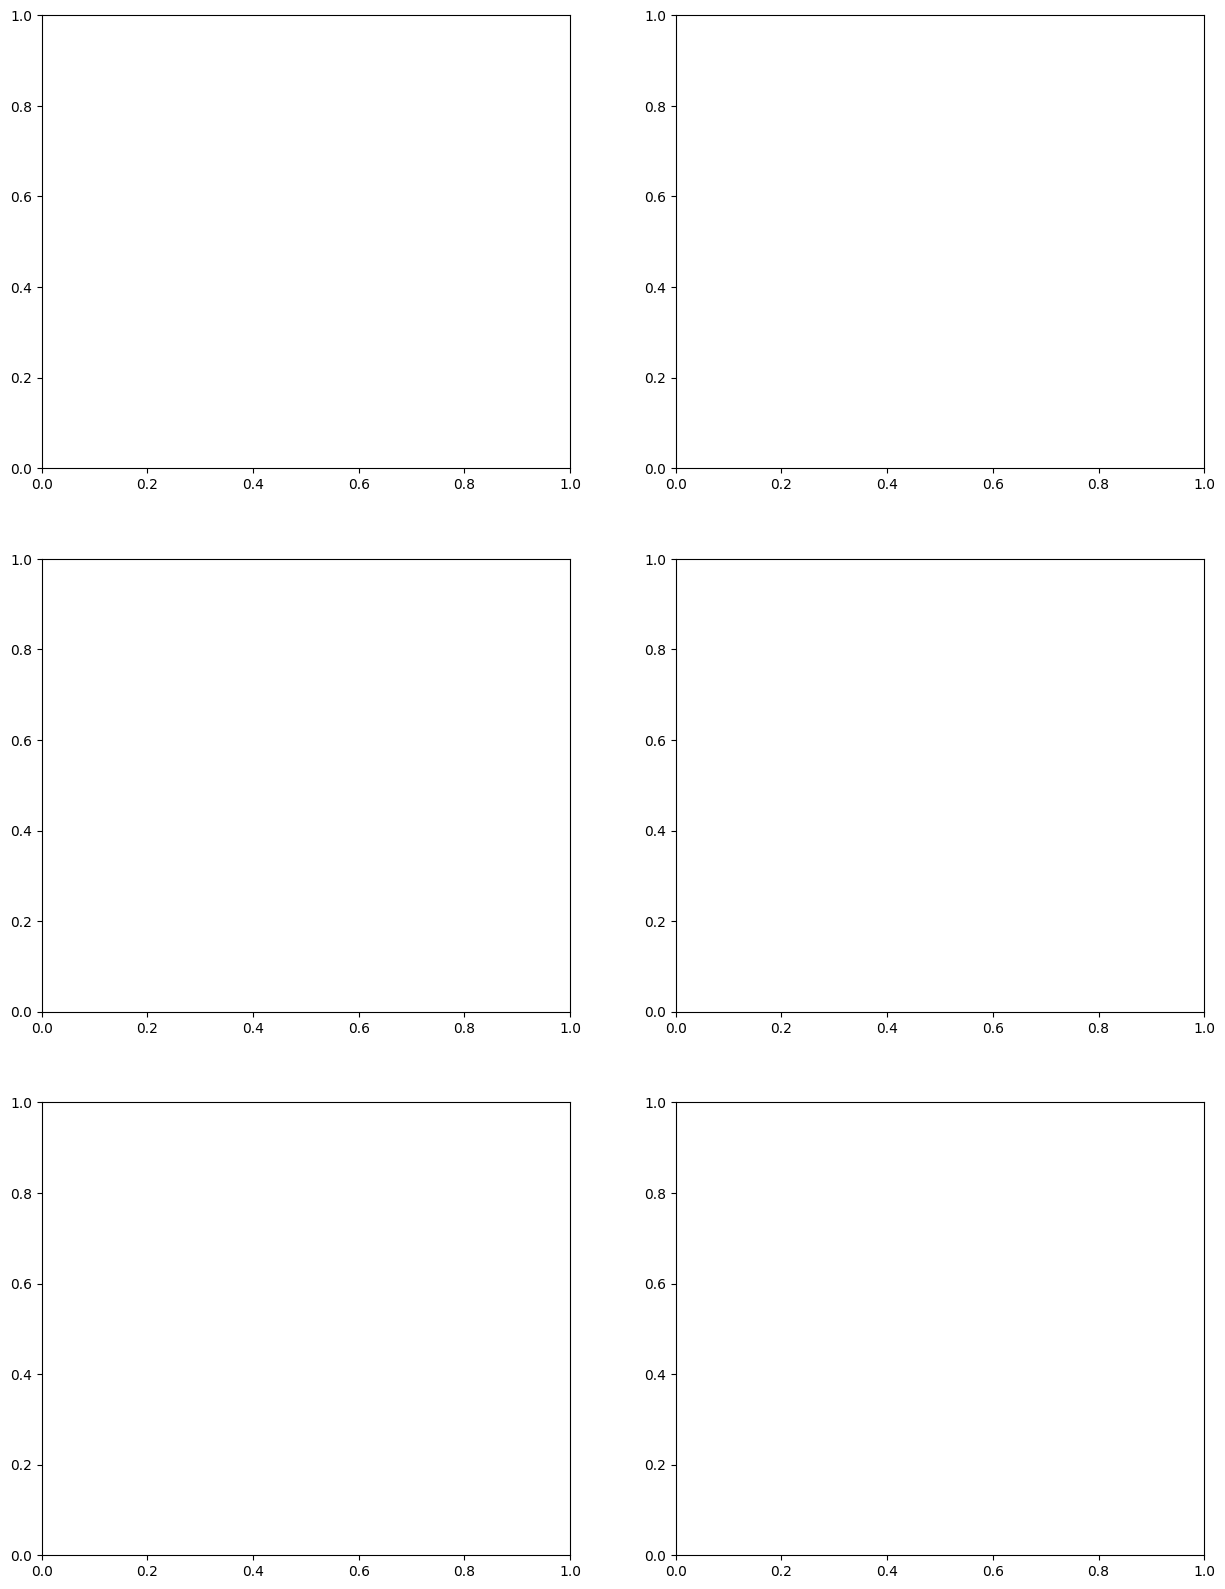

In [871]:
import seaborn as sns
import matplotlib.pyplot as plt

# Titles
titles = ['Yield Glucose', 'Yield XMG', 'Yield Monosacharides', 'Selectivity Glucose', 'Selectivity XMG', 'Selectivity Monosacharides']

# Create a consistent color palette
colors = sns.color_palette("Set2")

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, axs = plt.subplots(3, 2, figsize=(15,20))

# Plot each data set using a different color
for ax, df, title in zip(axs.flatten(), dataframes, titles):
    sns.barplot(data=df, x='Temperature (Celcius)', y='value', hue='NaOH and Duration', ci=None, ax=ax, width=0.5, palette=colors)
    ax.set_title(title)
    ax.set_ylabel('Value (%)')

# Add a legend to each plot
for ax in axs.flatten():
    ax.legend(loc='upper right')

# Add a grid to each plot
for ax in axs.flatten():
    ax.grid(True)

# Save the plots as high-quality images
#for ax in axs.flatten():
#    ax.figure.savefig(title + '.png', dpi=300)

plt.show()




C:\Users\olofs\AppData\Local\Temp\ipykernel_36404\4105987277.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Temperature (Celcius)', y='value', hue='NaOH and Duration', ci=None, ax=ax, width=0.5, palette=palette)
C:\Users\olofs\AppData\Local\Temp\ipykernel_36404\4105987277.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Temperature (Celcius)', y='value', hue='NaOH and Duration', ci=None, ax=ax, width=0.5, palette=palette)
C:\Users\olofs\AppData\Local\Temp\ipykernel_36404\4105987277.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Temperature (Celcius)', y='value', hue='NaOH and Duration', ci=None, ax=ax, width=0.5, palette=palette)
C:\Users\olofs\AppData\Local\Temp\ipykernel_36404\4105987277.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `err

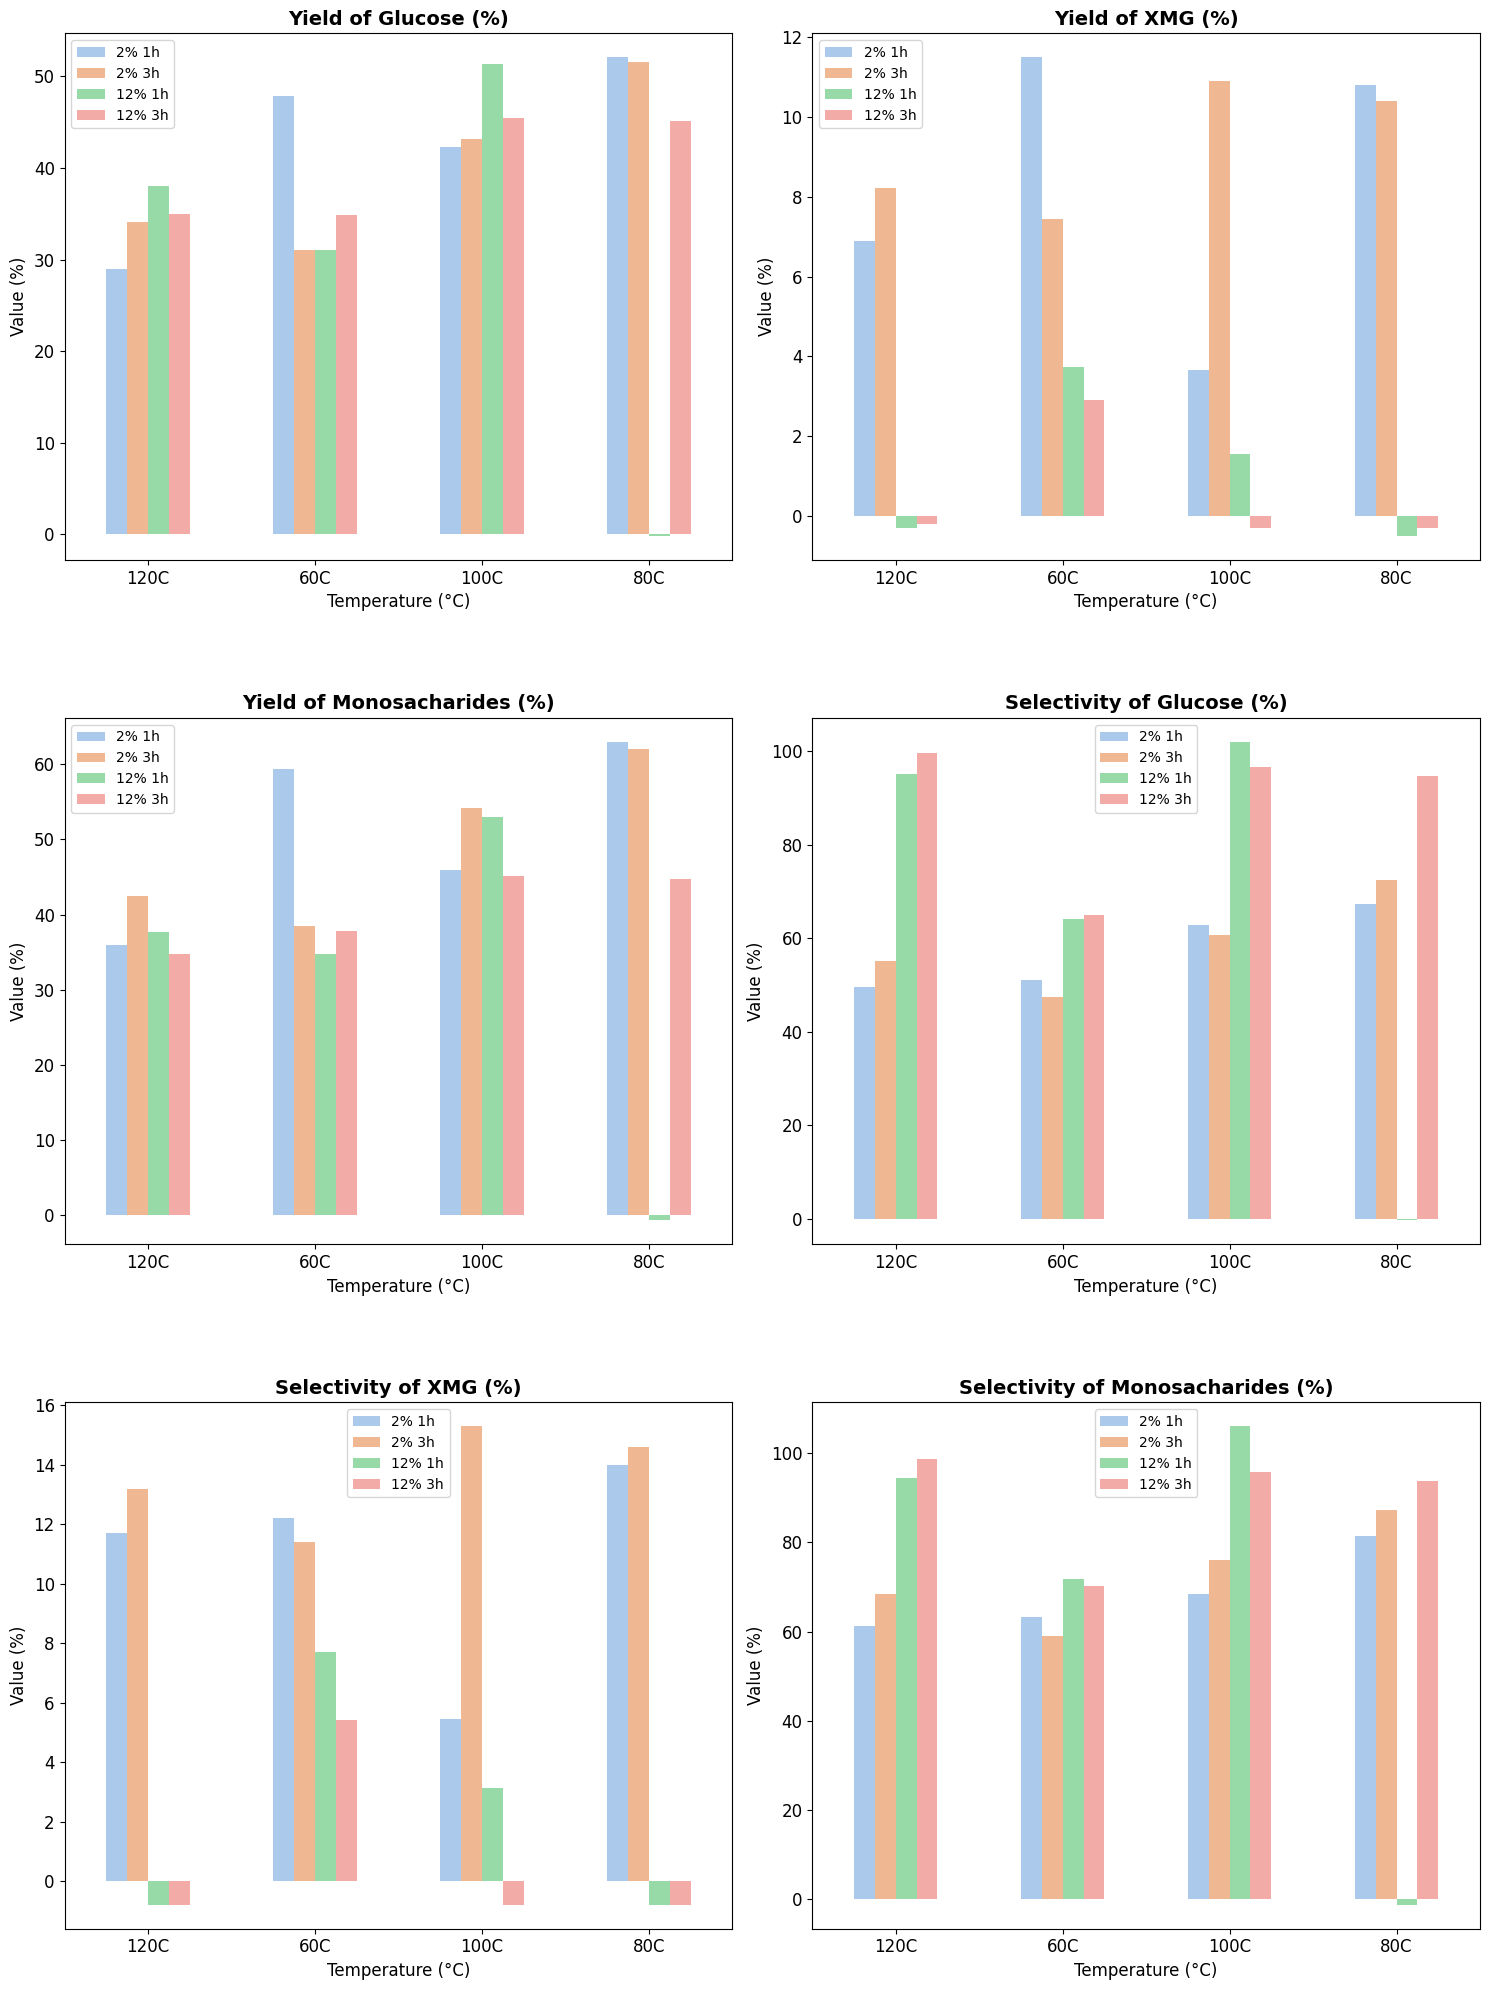

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your data
# ...

# Create DataFrames and add columns for the study conditions

df1 = pd.DataFrame(data1)
df1['Temperature (Celcius)'] = ['120C', '120C', '60C', '60C']
df1['NaOH and Duration'] = ['2% 1h', '2% 3h', '2% 1h', '2% 3h']

df2 = pd.DataFrame(data2)
df2['Temperature (Celcius)'] = ['120C', '120C', '60C', '60C']
df2['NaOH and Duration'] = ['12% 1h', '12% 3h', '12% 1h', '12% 3h']

df3 = pd.DataFrame(data3)
df3['Temperature (Celcius)'] = ['100C', '100C', '80C', '80C']
df3['NaOH and Duration'] = ['12% 1h', '12% 3h', '12% 1h', '12% 3h']

df4 = pd.DataFrame(data4)
df4['Temperature (Celcius)'] = ['100C', '100C', '80C', '80C']
df4['NaOH and Duration'] = ['2% 1h', '2% 3h', '2% 1h', '2% 3h']

# Combine all the dataframes into one
df = pd.concat([df1, df2, df3, df4])

# Melt the DataFrame to have only one value column
df_melted = df.melt(id_vars=['Temperature (Celcius)', 'NaOH and Duration'])

# Separate dataframes for each plot
yield_glucose_df = df_melted[df_melted['variable'] == 'Yield Glucose (%)']
yield_xmg_df = df_melted[df_melted['variable'] == 'Yield XMG (%)']
yield_monosacharides_df = df_melted[df_melted['variable'] == 'Yield Monosacharides (%)']
selectivity_glucose_df = df_melted[df_melted['variable'] == 'Selctivity Glucose (%)']
selectivity_xmg_df = df_melted[df_melted['variable'] == 'Selctivity XMG (%)']
selectivity_monosacharides_df = df_melted[df_melted['variable'] == 'Selctivity Monosacharides (%)']

dataframes = [yield_glucose_df, yield_xmg_df, yield_monosacharides_df, selectivity_glucose_df, selectivity_xmg_df, selectivity_monosacharides_df]
titles = ['Yield of Glucose (%)', 'Yield of XMG (%)', 'Yield of Monosacharides (%)', 'Selectivity of Glucose (%)', 'Selectivity of XMG (%)', 'Selectivity of Monosacharides (%)']

temperature_order = ['60C', '80C', '100C', '120C']

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, axs = plt.subplots(3, 2, figsize=(15,20))

palette = sns.color_palette("pastel")

for ax, df, title in zip(axs.flatten(), dataframes, titles):
    sns.barplot(data=df, x='Temperature (Celcius)', y='value', hue='NaOH and Duration', ci=None, ax=ax, width=0.5, palette=palette, order=temperature_order)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Temperature (°C)', fontsize=12)
    ax.set_ylabel('Value (%)', fontsize=12)
    ax.tick_params(labelsize=12)
    ax.legend(loc='best')

# Improve the layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()